Setup

In [1]:
from pathlib import Path
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

import models_mae
from flat_data import make_flat_wds_dataset, make_flat_transform
from util.visualization import FC_CMAP

plt.rcParams["figure.dpi"] = 100

Dataset

In [2]:
data_dir = Path("../datasets/fmri-fm.datasets")

# Load pretrained checkpoint
ckpt = torch.load(
    data_dir / "checkpoints/fm_mae_pretrain_vit_small.pth", weights_only=True
)
args = ckpt["args"]
state = ckpt["model"]

In [3]:
# Create dataset
dataset_files = sorted((data_dir / "hcp-flat/").glob("hcp-flat_*.tar"))
dataset = make_flat_wds_dataset(
    [str(f) for f in dataset_files],
    clipping="sequential",
    shuffle=False,
)

# Define transform
transform = make_flat_transform(
    img_size=(224, 560),
    clip_vmax=args["clip_vmax"],
    normalize=args["normalize"],
)
dataset = dataset.map(transform)
print(f"Found {len(dataset_files)} dataset shards.")  # N

Found 10 dataset shards.


In [4]:
# Select N examples for visualization
N = len(dataset_files)
samples = [sample for _, sample in zip(range(N), iter(dataset))]

sample_images = [
    s["image"].squeeze(0) if s["image"].shape[0] == 1 else s["image"] for s in samples
]
sample_masks = [
    s["mask"].squeeze(0) if s["mask"].shape[0] == 1 else s["mask"] for s in samples
]

all_sample_images = torch.stack(sample_images, dim=0)  # [N, frames, H, W]
all_sample_masks = torch.stack(sample_masks, dim=0)  # [N, 1, H, W]
print(
    f"Loaded {N} samples with shapes: images={all_sample_images.shape}, masks={all_sample_masks.shape}"
)

Loaded 10 samples with shapes: images=torch.Size([10, 16, 224, 560]), masks=torch.Size([10, 1, 224, 560])


Model

In [5]:
model = models_mae.__dict__[args["model"]](**args)
model.load_state_dict(state)
model.eval()

patch_size = args["t_patch_size"]
all_sample_images = all_sample_images.unsqueeze(1)  # [N, 1, frames, H, W]
print(f"model input shape={all_sample_images.shape}")

img_size (224, 560) patch_size (16, 16) frames 16 t_patch_size 16
model initialized
model input shape=torch.Size([10, 1, 16, 224, 560])


Embeddings

In [6]:
generator = torch.Generator().manual_seed(42)

with torch.inference_mode():
    embeddings = model.forward_embedding(all_sample_images, generator=generator)[
        2
    ]  # [N, n_patches, dim]
print(f"Extracted embeddings shape: {embeddings.shape}")

Extracted embeddings shape: torch.Size([10, 490, 384])


In [ ]:
# Build patch masks (to ignore background)
mask = F.avg_pool2d(
    all_sample_masks, kernel_size=patch_size, stride=patch_size
)  # [N, 1, H/patch_size, W/patch_size]
patch_mask = (mask > 0).view(N, -1)  # [N, n_patches]

all_embeddings = [embeddings[i][patch_mask[i]] for i in range(N)]
embeddings_for_pca = torch.cat(all_embeddings, dim=0)  # [total_patches, dim]
print(
    f"Total patches for PCA: {embeddings_for_pca.shape[0]}, embedding dim: {embeddings_for_pca.shape[1]}"
)

Total patches for PCA: 3640, embedding dim: 384


PCA

In [9]:
pca = PCA(
    n_components=3, whiten=True, random_state=42
)  # project embeddings to 3D for RGB visualization
x_pca = pca.fit_transform(embeddings_for_pca)  # [total_patches, 3]

In [10]:
# Reconstruct per-sample PCA maps
x_pca_samples = []
start_idx = 0
for i in range(N):
    mask = patch_mask[i].cpu().numpy()
    n_patches, valid_count = mask.shape[0], mask.sum()

    x_pca_full = np.full((n_patches, 3), 0.0)
    x_pca_full[mask] = x_pca[start_idx : start_idx + valid_count]

    x_pca_samples.append(x_pca_full)
    start_idx += valid_count

Visualization

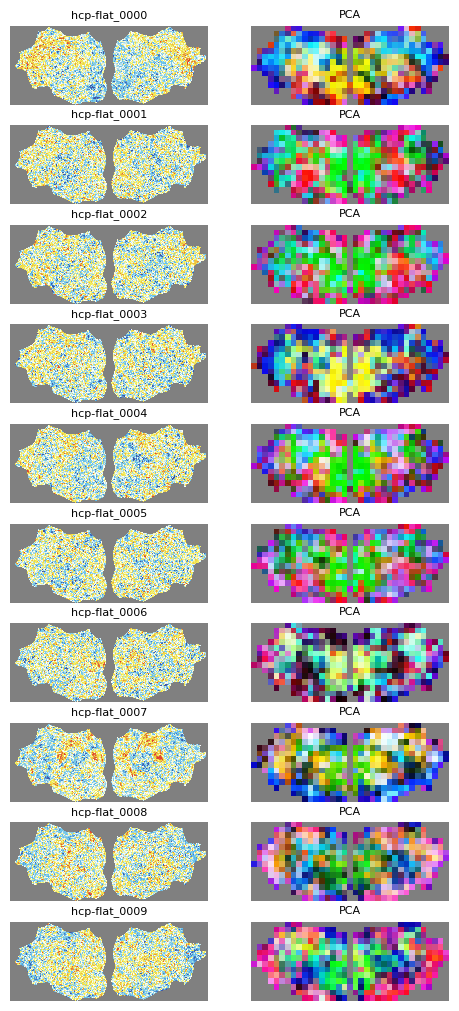

In [11]:
frame_idx = 0  # which frame to visualize
H, W = sample_images[0].shape[1:]  # original spatial size

ploth = 1.0
plotw = (W / H) * ploth

nr, nc = N, 2
f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))
axs = axs.flatten()

for i in range(N):
    # fMRI
    ax = axs[i * 2]  # first column
    img_orig = sample_images[i][frame_idx]  # select frame
    img_mask = sample_masks[i][0]
    img_orig = np.where(
        img_mask > 0, img_orig, np.nan
    )  # apply brain mask (outside = NaN)
    ax.imshow(img_orig, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
    ax.set_title(f"hcp-flat_000{i}", fontsize=8)
    ax.axis("off")

    # PCA
    ax = axs[i * 2 + 1]  # second column
    x_pca_i = x_pca_samples[i]  # [n_patches, 3]

    h_patches, w_patches = H // patch_size, W // patch_size
    projected_image = torch.from_numpy(x_pca_i).view(
        h_patches, w_patches, 3
    )  # reshape to patch grid

    # Multiply by 2.0 and pass through a sigmoid to get vibrant colors
    projected_image = (
        torch.sigmoid(projected_image * 2.0).permute(2, 0, 1).unsqueeze(0)
    )  # [1,3,h_patches,w_patches]

    ax.imshow(
        projected_image.squeeze(0).permute(1, 2, 0), interpolation="none"
    )  # [h_patches, w_patches, 3]
    ax.set_title("PCA", fontsize=8)
    ax.axis("off")

plt.tight_layout(pad=0.3)
plt.show()

In [12]:
# The End